# 单模型fine-tune

In [1]:
import h5py
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.callbacks import *
import matplotlib.pyplot as plt
import os

np.random.seed(2018)

/home/wson/anaconda3/envs/tf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def plot_history(history):
    # list all data in history
    # print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [3]:
input_size = (299, 299, 3)


## 预训练分类器

### 读取预训练数据

In [4]:
h5_file = "feature_Xception.h5"

with h5py.File(h5_file, 'r') as h:
    X_train = np.array(h['pretrain'])
    y_train = np.array(h['pretrain_label'])
    X_val = np.array(h['val'])
    y_val = np.array(h['val_label'])

X_train, y_train = shuffle(X_train, y_train)


In [6]:
print(X_train.shape, X_val.shape)

(1991, 2048) (4979, 2048)


### 构建分类器

In [7]:
def build_model(input_shape, drop_prob: float, lr=1e-2):
    input_tensor = Input(input_shape)
    x = Dropout(drop_prob)(input_tensor)
    x = Dense(1, activation='sigmoid', name='top_sigmoid')(x)
    model = Model(input_tensor, x)

    opt = optimizers.Adam(lr=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [21]:
model = build_model(X_train.shape[1:], 0.7, lr=1e-3)

### 使用10%的数据训练分类器

In [22]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min'),
             ModelCheckpoint(filepath='pretrain_Xception.h5', monitor='val_loss', verbose=0, save_best_only=True)]

history = model.fit(X_train, y_train, batch_size=128, epochs=50, validation_data=(X_val, y_val), callbacks=callbacks)

Train on 1991 samples, validate on 4979 samples
Epoch 1/50
1991/1991 [==============================] - 2s 920us/step - loss: 0.5517 - acc: 0.7509 - val_loss: 0.3429 - val_acc: 0.9865
Epoch 2/50
1991/1991 [==============================] - 0s 89us/step - loss: 0.2774 - acc: 0.9719 - val_loss: 0.1858 - val_acc: 0.9908
Epoch 3/50
1991/1991 [==============================] - 0s 84us/step - loss: 0.1682 - acc: 0.9864 - val_loss: 0.1238 - val_acc: 0.9916
Epoch 4/50
1991/1991 [==============================] - 0s 91us/step - loss: 0.1206 - acc: 0.9910 - val_loss: 0.0946 - val_acc: 0.9926
Epoch 5/50
1991/1991 [==============================] - 0s 114us/step - loss: 0.0970 - acc: 0.9900 - val_loss: 0.0776 - val_acc: 0.9930
Epoch 6/50
1991/1991 [==============================] - 0s 112us/step - loss: 0.0823 - acc: 0.9874 - val_loss: 0.0664 - val_acc: 0.9938
Epoch 7/50
1991/1991 [==============================] - 0s 118us/step - loss: 0.0725 - acc: 0.9910 - val_loss: 0.0586 - val_acc: 0.9938
Epo

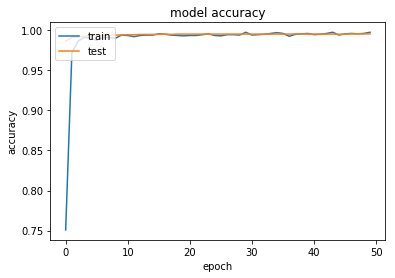

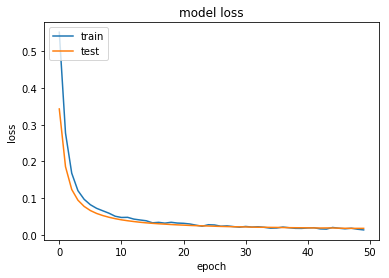

In [23]:
plot_history(history)

## 构建fine-tune模型

In [29]:
def build_finetune_model(MODEL, pre_process_func, input_size, trainable_layers: int, drop_prob: float, weights_file=None, lr=1e-4, decay=1e-6):
    input_tensor = Input(input_size)
    x = Lambda(pre_process_func)(input_tensor)
    
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    for layer in base_model.layers:
        layer.trainable = False
    
    if trainable_layers > 0:
        for layer in base_model.layers[-trainable_layers:]:
            layer.trainable = True
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(drop_prob)(x)
    pred = Dense(1, activation='sigmoid', name='top_sigmoid')(x)
    
    model = Model(base_model.input, pred)
    if weights_file:
        model.load_weights(weights_file)
    else:
        model.load_weights('pretrain_Xception.h5', by_name=True)
    opt = optimizers.Adam(lr=lr, decay=decay)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model
    

In [5]:
model = build_finetune_model(Xception, xception.preprocess_input, input_size=input_size, trainable_layers=6, drop_prob=0.8)

In [28]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 299, 299, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         lambda_4[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_con

### 使用剩余90%训练数据fine-tune模型

In [14]:
batch_size = 64
img_gen = ImageDataGenerator()
aug_img_gen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                                 shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

In [15]:
train_data_gen = aug_img_gen.flow_from_directory('finetune', input_size[:-1], class_mode='binary', batch_size=batch_size)
validation_gen = img_gen.flow_from_directory('val', input_size[:-1], class_mode='binary', batch_size=batch_size)

Found 17925 images belonging to 2 classes.
Found 4979 images belonging to 2 classes.


测试预训练模型：

In [33]:
model.evaluate_generator(validation_gen, steps=len(validation_gen))

[0.01791653083628004, 0.9955814420566379]

调整模型参数：

In [16]:
model = build_finetune_model(Xception, xception.preprocess_input, input_size=input_size, trainable_layers=6, drop_prob=0.8)

训练模型：

In [17]:
callbacks = [EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min'),
             ModelCheckpoint(filepath='finetune_Xception.h5', monitor='val_loss', verbose=0, save_best_only=True)]

history = model.fit_generator(train_data_gen, steps_per_epoch=len(train_data_gen), epochs=20,
                              validation_data=validation_gen, validation_steps=len(validation_gen), callbacks=callbacks)

Epoch 1/20
281/281 [==============================] - 468s 2s/step - loss: 0.0831 - acc: 0.9729 - val_loss: 0.0129 - val_acc: 0.9972
Epoch 2/20
281/281 [==============================] - 451s 2s/step - loss: 0.0438 - acc: 0.9832 - val_loss: 0.0128 - val_acc: 0.9970
Epoch 3/20
281/281 [==============================] - 477s 2s/step - loss: 0.0357 - acc: 0.9864 - val_loss: 0.0123 - val_acc: 0.9968
Epoch 4/20
281/281 [==============================] - 461s 2s/step - loss: 0.0299 - acc: 0.9885 - val_loss: 0.0127 - val_acc: 0.9968
Epoch 5/20
281/281 [==============================] - 474s 2s/step - loss: 0.0244 - acc: 0.9908 - val_loss: 0.0139 - val_acc: 0.9960
Epoch 6/20
281/281 [==============================] - 454s 2s/step - loss: 0.0212 - acc: 0.9912 - val_loss: 0.0139 - val_acc: 0.9956
Epoch 7/20
281/281 [==============================] - 458s 2s/step - loss: 0.0199 - acc: 0.9921 - val_loss: 0.0109 - val_acc: 0.9966
Epoch 8/20
281/281 [==============================] - 462s 2s/step - 

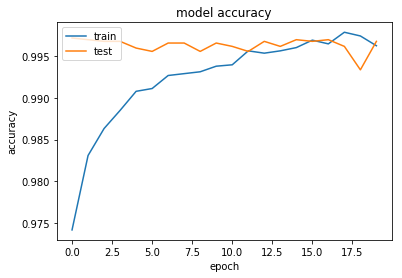

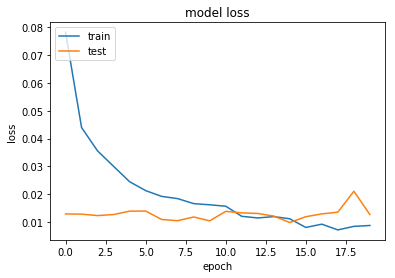

In [18]:
plot_history(history)

由于dropout和图像增强的影响，需要重新评估训练误差，判断过拟合程度：

In [20]:
train_data_gen = img_gen.flow_from_directory('finetune', input_size[:-1], class_mode='binary', batch_size=batch_size)

Found 17925 images belonging to 2 classes.


In [21]:
model.load_weights('finetune_Xception.h5')
model.evaluate_generator(train_data_gen, steps=len(train_data_gen))

[0.004212250069784818, 0.9984937238493724]

## 预测测试集数据

In [10]:
model.load_weights('finetune_Xception.h5')

In [ ]:
img_gen = ImageDataGenerator()

In [23]:
test_data_gen = img_gen.flow_from_directory('test', (input_size[:-1]), shuffle=False, batch_size=batch_size)

Found 12500 images belonging to 1 classes.


In [55]:
y_pred = model.predict_generator(test_data_gen, len(test_data_gen), verbose=1)
y_pred_clip = y_pred.clip(min=0.005, max=0.995)

196/196 [==============================] - 137s 701ms/step


In [56]:
df = pd.read_csv("sampleSubmission.csv")

for i, fname in enumerate(test_data_gen.filenames):
    index = int(fname[fname.rfind(os.sep) + 1:fname.rfind('.')])
    df.loc[index-1, ['label']] = y_pred_clip[i]

df.to_csv('pred.csv', index=None)
df.head(10)


,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005
